# Search for Sentinel-2 data from the Copernicus Open Access Hub

In this notebook we query the [Copernicus Open Access Hub API](https://scihub.copernicus.eu) for the Sentinel-2 scenes intersecting a glacier geometry, as extracted from the [Randolph Glacier Inventory (RGI)](http://www.glims.org/RGI/).

In [19]:
import getpass
import os

import geojson
import geopandas as gpd
import pandas as pd
import sentinelsat
import shapely.geometry

from dhdt.auxilary.handler_randolph import download_rgi

## Define the area-of-interest (AOI) using the RGI

We define the coordinates of a point on the glacier of interest and download the corresponding RGI files:

In [2]:
# Brintnell-Bologna Icefield (Northwest Territories)
lat = 62.09862204
lon = -127.9693738

# download RGI files, get the path to the shapefiles
rgi_paths = download_rgi(
    aoi=(lat, lon), 
    rgi_dir="./data/RGI"
)

We load the RGI region as a `GeoDataFrame` and identify the glacier by intersecting it with the defined point:

In [3]:
point = shapely.geometry.Point(lon, lat)
glaciers = pd.concat([gpd.read_file(p) for p in rgi_paths])
mask = glaciers.intersects(point)
glacier = glaciers[mask]

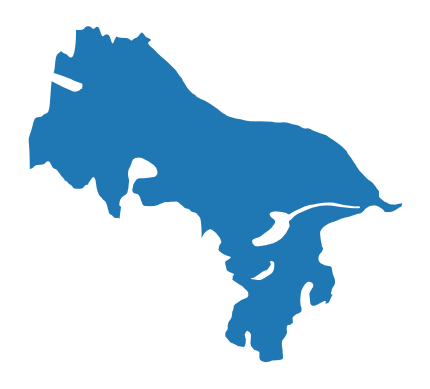

In [4]:
# plot out the glacier
ax = glacier.plot()
ax.set_axis_off()

Finally, we extract the glacier's geometry to setup the query:

In [5]:
glacier_geometry = glacier.geometry.squeeze()

## Copernicus Open Access Hub

We set the credentials to access Copernicus Open Access Hub (register at [this link](https://scihub.copernicus.eu/userguide/SelfRegistration)):

In [6]:
username = getpass.getpass("username")
password = getpass.getpass("password")

username ········
password ········


The API endpoint is available at the following link:

In [7]:
api_url = "https://apihub.copernicus.eu/apihub"

## Imagery search with Sentinelsat

We look for the Sentinel-2 scenes that contains the AOI, using [Sentinelsat](https://github.com/sentinelsat/sentinelsat) to query the Copernicus API:

In [10]:
api = sentinelsat.SentinelAPI(
    user=username, 
    password=password, 
    api_url=api_url,
    show_progressbars=False,
)

In dhdt we use images processed at **Level-1C** (L1C, top-of-atmosphere reflectance). We use the envelope of the glacier geometry to define the area of interest and consider scenes with an estimated cloud coverage up to 70%:  

In [13]:
area = glacier_geometry.envelope.wkt

scenes_l1c = api.query(
    platformname="Sentinel-2",
    producttype="S2MSI1C",
    area=area,
    area_relation="Contains",
    cloudcoverpercentage=(0, 70),
)

We then look for the corresponding scenes processed at **Level-2A** (L2A, bottom-of-atmosphere reflectance), which include a scene classification layer that will allow us to mask out clouds. 

First we query for all L2A scenes matching our AOI:

In [14]:
scenes_l2a = api.query(
    platformname="Sentinel-2",
    producttype="S2MSI2A",
    area=area,
    area_relation="Contains",
)

We then look for the L2A scenes for which we have the corresponding L1C scenes: 

In [15]:
# convert search results to GeoDataFrames
gdf_l1c = api.to_geodataframe(scenes_l1c)
gdf_l2a = api.to_geodataframe(scenes_l2a)

# match scene records
merged = gdf_l1c.merge(
    gdf_l2a.dropna(subset="level1cpdiidentifier"),
    how="left", 
    on="level1cpdiidentifier", 
    validate="1:1",
    suffixes=["_L1C", "_L2A"]
)

# extract IDs of the L2A scenes matching L1C ones
uuid_l2a = merged["uuid_L2A"].dropna().values

# get corresponding L2A scenes
scenes_l2a_matched = {uuid: scenes_l2a[uuid] for uuid in uuid_l2a}

Print number of selected scenes:

In [16]:
len(scenes_l1c), len(scenes_l2a_matched)

(486, 321)

Finally we convert the search results to GeoJSON, and write out the corresponding files:

In [20]:
def write_to_file(api, scenes, filepath):
    
    # create directory if it does not exists
    dirname = os.path.dirname(filepath)
    os.makedirs(dirname, exist_ok=True)
    
    with open(filepath, "w") as f:
        feature_collection = api.to_geojson(scenes)
        geojson.dump(feature_collection, f)   

In [22]:
write_to_file(
    api, 
    scenes_l1c, 
    "./data/sentinel-2/sentinel2-l1c.json"
)
write_to_file(
    api, 
    scenes_l2a_matched, 
    "./data/sentinel-2/sentinel2-l2a.json"
)

## Imagery download

Sentinelsat also provides tools to download Sentinel data products from the Copernicus Open Access Hub. However, only the most recent images (last 12 months) are kept online, while older images are moved to the [Long Term Archive (LTA)](https://sentinels.copernicus.eu/web/sentinel/-/activation-of-long-term-archive-lta-access-for-copernicus-sentinel-2-and-3). Users can request images to be brought online, with a daily quota.

Alternative sources of Sentinel-2 imagery are:
- The [Sentinel-2 Open Data collection on AWS](https://registry.opendata.aws/sentinel-2-l2a-cogs/). Data can be discovered via the [Earth Search](https://stacindex.org/catalogs/earth-search#/) SpatioTemporal Asset Catalog (STAC) API. This collection offers free L2A data products converted to cloud-optimized GeoTIFFs. 
- The [Sentinel-2 public dataset](https://cloud.google.com/storage/docs/public-datasets/sentinel-2) that is made available as a [bucket](https://console.cloud.google.com/storage/browser/gcp-public-data-sentinel-2) on Google Cloud Storage (GCS). Complete L1C and L2A datasets are available in the original format, including the full set of metadadata files.

[Here](https://github.com/GO-Eratosthenes/dhdt/tree/master/scripts/sentinel-2-imagery) we provide a script to convert the Sentinelsat search results to STAC, linking the most relevant Sentinel-2 data products to the corresponding files on GCS. The same script also allows to retrieve these assets.  